# Binary Classification

In [9]:
from kiwigrad import MLP, Layer, Value
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
def accuracy_val(model, X ,y_true):
    y_pred = np.array([model(X[i]).sigmoid().data for i in range(X.shape[0])]).round()
    correct_results = np.sum(y_pred == y_true)
    acc = correct_results/y_true.shape[0]
    acc = np.round(acc * 100)
    return acc

### Dataset

In [3]:
X, y = make_moons(n_samples=100, noise=0.1)
print(X.shape, type(X))
print(y.shape, type(y))

(100, 2) <class 'numpy.ndarray'>
(100,) <class 'numpy.ndarray'>


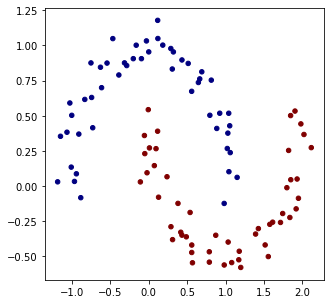

In [4]:
# visualize dataset
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

### Full Batch Gradient Descent with BCE loss

In [5]:
class PotNet(MLP):
    def __init__(self):
        layers = [
            Layer(nin=2, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=1, bias=True, activation="linear")
        ]
        super().__init__(layers=layers)

model = PotNet()

In [6]:
epochs = 100 
for epoch in range(epochs): 
    for i in range(X.shape[0]):
        output = model(X[i]).sigmoid()
        neg_output = 1-output
        target = y[i]
        bce_loss = -(target * output.log() + (1 - target) * neg_output.log())
        bce_loss.backward()
        for p in model.parameters():
            p.data += -0.001 * p.grad 
        model.zero_grad()
    acc = accuracy_val(model=model, X=X, y_true=y)
    if epoch%10 == 0:
        print(f"epoch: {epoch} |", f"loss: {bce_loss.data:.2f} |", f"accuracy: {acc}")

epoch: 0 | loss: 0.44 | accuracy: 76.0
epoch: 10 | loss: 0.43 | accuracy: 78.0
epoch: 20 | loss: 0.46 | accuracy: 81.0
epoch: 30 | loss: 0.47 | accuracy: 83.0
epoch: 40 | loss: 0.44 | accuracy: 83.0
epoch: 50 | loss: 0.42 | accuracy: 88.0
epoch: 60 | loss: 0.39 | accuracy: 88.0
epoch: 70 | loss: 0.35 | accuracy: 88.0
epoch: 80 | loss: 0.30 | accuracy: 88.0
epoch: 90 | loss: 0.28 | accuracy: 90.0


(-1.5789640090910926, 2.1710359909089076)

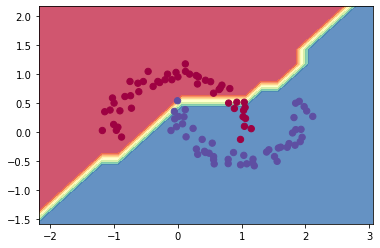

In [10]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())